In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import mnist
from keras.layers import Dense, Flatten, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
from keras.optimizers import Adam


In [5]:
#Defining the MNIST input dimensions with a single channel for grayscale images
# z_dim is the noise vector for the G

img_rows= 28
img_cols= 28
channels =1

img_shape= (img_rows, img_cols, channels)
z_dim= 100

In [6]:
#Building Generator Network
def build_generator(img_shape, z_dim):
    model= Sequential()
    model.add(Dense(128, input_dim= z_dim))
    model.add(LeakyReLU(alpha=0.01)) #Leakyrelu helps to avoid the risk of dying gradients
    model.add(Dense(28*28*1, activation='tanh'))  #compared to sigmoid, tanh produces [-1,1] range output, with cripiers images
    model.add(Reshape(img_shape))
    
    return model

In [8]:
#Discriminator Code 
def build_discriminator(img_shape):
    model=Sequential()
    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [9]:
#Combined model (G,D)

def build_gan(generator, discriminator):
    model=Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

discriminator= build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

generator= build_generator(img_shape,z_dim)
discriminator.trainable= False

gan= build_gan(generator,discriminator)

gan.compile(loss='binary_crossentropy', optimizer= Adam())






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [24]:
#Generating sample images from training generator

def sample_images(generator, image_grid_rows=4, image_grid_columns=4):
    
    z= np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))
    
    gen_images= generator.predict(z)
    
    gen_images= 0.5 * gen_images + 0.5 #rescaling to [0,1]
    
    fig, axs = plt.subplots(image_grid_rows,                    #Set image grid              
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):                   #output images
            axs[i, j].imshow(gen_images[cnt, :, :, 0], cmap='gray')             
            axs[i, j].axis('off')
            cnt += 1
            
    

1000 [D loss: 0.167823, acc.: 94.53%] [G loss: 3.660383]
2000 [D loss: 0.283728, acc.: 88.67%] [G loss: 4.122692]
3000 [D loss: 0.281094, acc.: 85.55%] [G loss: 3.245765]
4000 [D loss: 0.424065, acc.: 83.20%] [G loss: 3.868656]
5000 [D loss: 0.386777, acc.: 83.98%] [G loss: 4.628713]
6000 [D loss: 0.594625, acc.: 77.34%] [G loss: 3.282515]
7000 [D loss: 0.420685, acc.: 83.20%] [G loss: 3.064269]
8000 [D loss: 0.469482, acc.: 78.12%] [G loss: 3.216844]
9000 [D loss: 0.277455, acc.: 88.28%] [G loss: 4.147026]
10000 [D loss: 0.533194, acc.: 75.39%] [G loss: 2.216481]
11000 [D loss: 0.492015, acc.: 82.03%] [G loss: 3.254961]
12000 [D loss: 0.344301, acc.: 82.81%] [G loss: 2.541057]
13000 [D loss: 0.339665, acc.: 84.38%] [G loss: 3.314683]
14000 [D loss: 0.408653, acc.: 82.42%] [G loss: 2.858138]
15000 [D loss: 0.357774, acc.: 83.59%] [G loss: 3.255646]
16000 [D loss: 0.438909, acc.: 80.86%] [G loss: 2.693989]
17000 [D loss: 0.296616, acc.: 86.33%] [G loss: 2.834566]
18000 [D loss: 0.465516

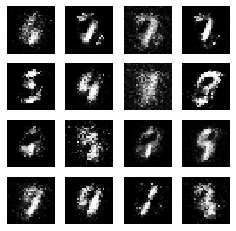

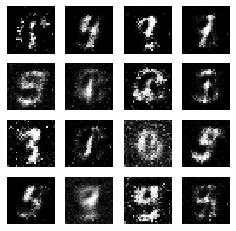

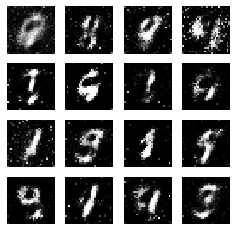

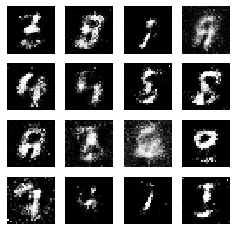

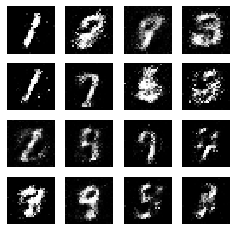

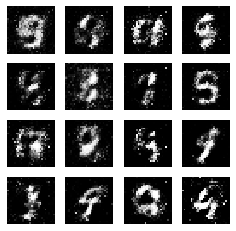

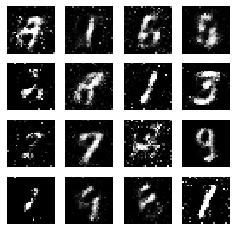

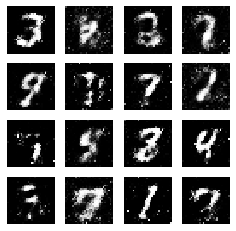

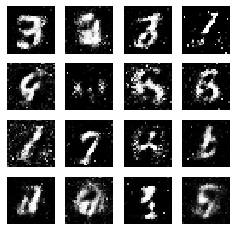

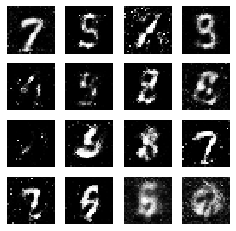

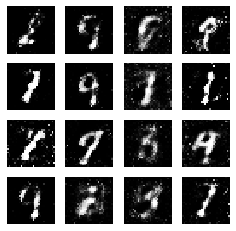

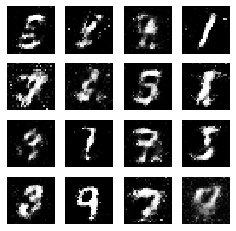

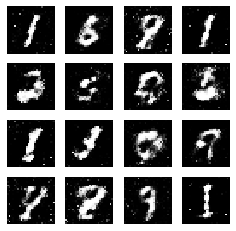

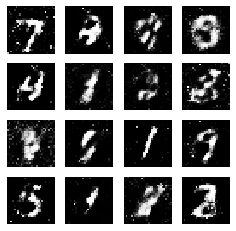

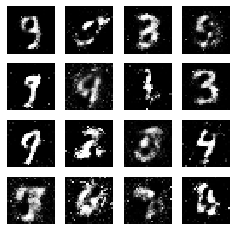

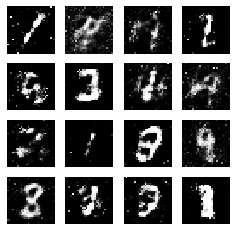

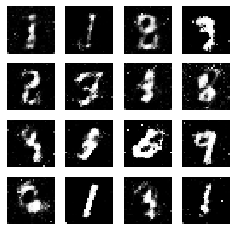

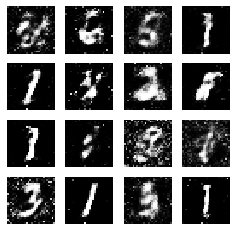

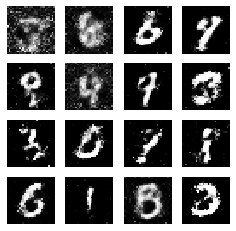

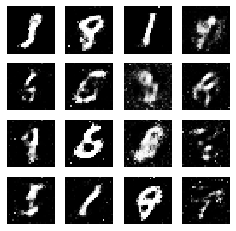

In [25]:
 #Training the GAN

losses=[]
accuracies=[]
iteration_checkpoints=[]

def train(iterations, batch_size, sample_interval):
    
    (X_train, _),(_,_)=mnist.load_data()
    
    X_train= X_train /127.5 - 1   #rescaling to [-1,1]
    
    X_train = np.expand_dims(X_train, axis=3)
     
    real= np.ones((batch_size,1))    #Labels for real images
    fake= np.zeros((batch_size,1))   #Labels for fake images
    
    for iteration in range(iterations):
        
        idx = np.random.randint(0, X_train.shape[0], batch_size)  #random no. indexes in range of len(X_train) of batch_size len
        
        images= X_train[idx]   #fetched a batch of real images
        
        z = np.random.normal(0, 1, (batch_size, 100))  #Distribution for batch of fake images
        
        gen_images= generator.predict(z)
        
        disc_loss_real= discriminator.train_on_batch(images, real) #fetching loss on real vs train images
        
        disc_loss_fake= discriminator.train_on_batch(gen_images, fake) #fetching loss on fake vs generated images
        
        disc_loss, accuracy= 0.5 * np.add(disc_loss_real, disc_loss_fake)
        
        #Now keeping the disc parameters constant, and training the generator
        
        z = np.random.normal(0, 1, (batch_size, 100))        #First creating a batch of images from distribution       
        
        gen_imgs = generator.predict(z)   #Then creating a batch of fake images
        
        g_loss = gan.train_on_batch(z, real)
        
        if(iteration+1) %sample_interval ==0:
            
            losses.append((disc_loss, g_loss))
            
            accuracies.append(100* accuracy)
            
            iteration_checkpoints.append(iteration+1)
            
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %(iteration + 1, disc_loss, 100.0 * accuracy, g_loss))

            sample_images(generator)
            
        
      
        
iterations = 20000                                
batch_size = 128
sample_interval = 1000

train(iterations, batch_size, sample_interval)
    